Covid 19 CT scan Image classification with VGG19 pretrained model.

Datasets: 2 public datasets stored in the folders CT_DATA (CT_COVID and CT_NonCovid) and SARS-COV-2-DATA.
https://www.kaggle.com/plameneduardo/sarscov2-ctscan-dataset

https://github.com/UCSD-AI4H/COVID-CT

DATA-Split folder : initially used to split data from CT-DATA, but will not be used here in the final.


In [1]:
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import os
import cv2
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
cov_path = "/content/drive/MyDrive/Colab Notebooks/CTCov/CT_Data/CT_COVID/"
norm_path = "/content/drive/MyDrive/Colab Notebooks/CTCov/CT_Data/CT_NonCOVID/"

In [4]:
IMAGE_SIZE=[224,224]
epochs = 300
batch_size=32
#define paths
covid_path = '/content/drive/MyDrive/Colab Notebooks/CTCov/SARS-COV-2-Data/COVID'
noncovid_path = '/content/drive/MyDrive/Colab Notebooks/CTCov/SARS-COV-2-Data/NON-COVID'

# Use glob to grab images from path .jpg or jpeg
cov_files = glob(cov_path + '/*')
norm_files = glob(norm_path + '/*')

covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

In [5]:
# Fetch Images and Class Labels from Files
cov_labels = []
norm_labels = []

cov_images=[]
norm_images=[]

for i in range(len(cov_files)):
  image = cv2.imread(cov_files[i]) # read file 
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # arrange format as per keras
  image = cv2.resize(image,(224,224)) # resize as per model
  cov_images.append(image) # append image
  cov_labels.append('CT_COVID') #append class label
  
for i in range(len(norm_files)):
  image = cv2.imread(norm_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image = cv2.resize(image,(224,224))
  norm_images.append(image)
  norm_labels.append('CT_NonCOVID')

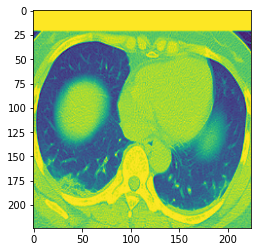

In [6]:
plt.imshow(cov_images[10])

In [7]:
# Fetch Images and Class Labels from Files
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i]) # read file 
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # arrange format as per keras
  image = cv2.resize(image,(224,224)) # resize as per model
  covid_images.append(image) # append image
  covid_labels.append('CT_COVID') #append class label
  
for i in range(len(noncovid_files)):
  image = cv2.imread(noncovid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image = cv2.resize(image,(224,224))
  noncovid_images.append(image)
  noncovid_labels.append('CT_NonCOVID')

In [8]:
covid_images = np.concatenate((covid_images, cov_images), axis=0)
noncovid_images = np.concatenate((noncovid_images, norm_images),axis=0)

In [9]:
covid_labels = np.concatenate((covid_labels, cov_labels), axis=0)
noncovid_labels = np.concatenate((noncovid_labels, norm_labels),axis=0)

In [10]:
len(covid_images)

1598

#CLAHE

In [11]:
clahe = cv2.createCLAHE(clipLimit=4.0)

In [13]:
clahe_cov_img = [clahe.apply(img) for img in covid_images]
clahe_norm_img = [clahe.apply(img) for img in noncovid_images]

In [14]:
rgb_cov = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in clahe_cov_img]

In [15]:
rgb_norm = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in clahe_norm_img]

In [16]:
len(rgb_cov)

1598

Normalize

In [17]:
covid_images = np.array(rgb_cov)/255
noncovid_images = np.array(rgb_norm)/255

In [18]:
# Split into training and testing sets for both types of images
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)

# Merge sets for both types of images
X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# Make labels into categories - either 0 or 1, for our model
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)


# DenseNet model

In [19]:
from tensorflow.keras.applications import DenseNet121

from sklearn.model_selection import KFold

kfold = KFold(n_splits=3, shuffle=True)
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

# Building Model
acc_per_fold = []
loss_per_fold = []
fold_no = 1

densenet = DenseNet121(weights="imagenet", include_top=False,
  input_tensor=Input(shape=(224, 224, 3)))

for layer in densenet.layers:
      layer.trainable = False

train_aug = ImageDataGenerator(
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True
  )

for train, test in kfold.split(inputs, targets):

  outputs = densenet.output
  outputs = Flatten(name="flatten")(outputs)
  outputs = Dropout(0.5)(outputs)
  outputs = Dense(2, activation="softmax")(outputs)

  model = Model(inputs=densenet.input, outputs=outputs)


  model.compile(
          loss='categorical_crossentropy', 
          optimizer='adam', 
          metrics=['accuracy']
  )

  

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  model.fit(train_aug.flow(inputs[train], targets[train], batch_size=batch_size),
                    verbose=1,
                    epochs=100)
  
  # Generate generalization metrics
  scores = model.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

29097984/29084464 [==============================] - 0s 0us/step
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
68/68 [==============================] - 33s 287ms/step - loss: 2.1587 - accuracy: 0.6459
Epoch 2/100
68/68 [==============================] - 20s 287ms/step - loss: 1.7284 - accuracy: 0.7092
Epoch 3/100
68/68 [==============================] - 20s 288ms/step - loss: 1.7137 - accuracy: 0.7455
Epoch 4/100
68/68 [==============================] - 20s 291ms/step - loss: 2.0014 - accuracy: 0.7413
Epoch 5/100
68/68 [==============================] - 20s 288ms/step - loss: 1.6826 - accuracy: 0.7729
Epoch 6/100
68/68 [==============================] - 20s 287ms/step - loss: 1.8603 - accuracy: 0.7645
Epoch 7/100
68/68 [==============================] - 20s 287ms/step - loss: 1.7159 - accuracy: 0.7804
Epoch 8/100
68/68 [==============================] - 20s 290ms/step - loss: 1.6833 - accuracy: 0.7743
Epoch 9/100
68/68 [===

In [20]:
import pandas as pd
metrics = pd.DataFrame(acc_per_fold)
metrics = metrics.rename(columns={0:'accuracy'})
loss_df = pd.DataFrame(loss_per_fold)

In [21]:
metrics.head()

,accuracy
0,85.209304
1,83.069766
2,79.422718


In [22]:
metrics_df = metrics.join(loss_df.rename(columns={0:'loss'}))

In [23]:
metrics_df.head()

,accuracy,loss
0,85.209304,2.325323
1,83.069766,2.386273
2,79.422718,3.803458


In [24]:
report_csv_file = '/content/drive/MyDrive/Colab Notebooks/CTCov/Fold/DenseNet121/densenet_clahe_class_report.csv'
with open(report_csv_file, mode='w') as f:
    metrics_df.to_csv(f)